# Detecting Emotion From Speech With Machine Learning
### Author: Rishi Sinha

Recognizing emotion does not just rely on words the person is saying, rather, human beings are capable of recognizing the emotional state of the speaker though attributes such as the tone and pitch of the voice. Pets are also capable of recognizing emotion, even though they do not understand the words that are being spoken. The goal of this project is to develop and train a Machine Learning (ML) model that can detect emotion from audio speech samples.

I used the [RAVDESS](https://smartlaboratory.org/ravdess/) (Ryerson Audio-Visual Database of Emotional Speech and Song) dataset which contains 7,356 files from 24 professional actors (12 female, 12 male), vocalizing two lexically matched statements to train my model. Emotions included were calm, happy, sad, angry, fearful, surprise, and disgust.

In [1]:
# Load modules
import librosa
import soundfile
import os, glob, pickle
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
import IPython.display as ipd
import matplotlib.pyplot as plt
import librosa.display
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

## Load Dataset and Analyze Samples
The entire RAVDESS dataset is over 24 GB. I've used a lower sample rate version available for download [here](https://drive.google.com/file/d/1wWsrN2Ep7x6lWqOXfr4rpKGYrJhWc8z7/view).
Used features such as Mel Spectrogram and Chroma extracted using [librosa](https://librosa.org/doc/main/auto_examples/plot_display.html).

In [2]:
# Emotions in the RAVDESS dataset
emotions={
  '01':'neutral',
  '02':'calm',
  '03':'happy',
  '04':'sad',
  '05':'angry',
  '06':'fearful',
  '07':'disgust',
  '08':'surprised'
}

# Invert dictionary for convenience
inv_emotions = {v: k for k, v in emotions.items()}

# Using a sample of emotions for the project to observe
observed_emotions=['calm', 'happy', 'fearful', 'surprised']
print("Emotions used for training and testing: " + str(observed_emotions))

Emotions used for training and testing: ['calm', 'happy', 'fearful', 'surprised']


In [3]:
# Utility function to read a soundfile and return samples and sample rate
def read_soundfile(filename):
        with soundfile.SoundFile(sample_audio_file) as sound_file:
            X = sound_file.read(dtype="float32")
            sample_rate=sound_file.samplerate
        return(X, sample_rate)

In [4]:
# Choose two sample actors (male and female) and play the files for observed emotions
dataset_dir = "ser-ravdess-data/"
for actor in ['01', '12']:
    for emotion in observed_emotions:
        sample_actor = "Actor_" + actor
        sample_audio_file = dataset_dir + sample_actor + "/03-01-" + inv_emotions[emotion] + "-01-02-01-" + actor + ".wav"
        X, sample_rate=read_soundfile(sample_audio_file)
        print( sample_actor + " | " + emotion + " | " + sample_audio_file)
        ipd.display(ipd.Audio(X, rate=sample_rate))


Actor_01 | calm | ser-ravdess-data/Actor_01/03-01-02-01-02-01-01.wav


Actor_01 | happy | ser-ravdess-data/Actor_01/03-01-03-01-02-01-01.wav


Actor_01 | fearful | ser-ravdess-data/Actor_01/03-01-06-01-02-01-01.wav


Actor_01 | surprised | ser-ravdess-data/Actor_01/03-01-08-01-02-01-01.wav


Actor_12 | calm | ser-ravdess-data/Actor_12/03-01-02-01-02-01-12.wav


Actor_12 | happy | ser-ravdess-data/Actor_12/03-01-03-01-02-01-12.wav


Actor_12 | fearful | ser-ravdess-data/Actor_12/03-01-06-01-02-01-12.wav


Actor_12 | surprised | ser-ravdess-data/Actor_12/03-01-08-01-02-01-12.wav


### Feature Analysis

#### Mel Spectogram
A [spectrogram](https://en.wikipedia.org/wiki/Spectrogram) is a visual representation of the spectrum of frequencies of a signal as it varies with time. It captures the amount of energy in different frequencies of the signal over small time windows. The spectrogram is a 3D plot. The X axis is time, the Y axis is frequency and the the colors represent the amount of energy in each time/frequency bucket. The [Mel Spectrogram](https://medium.com/analytics-vidhya/understanding-the-mel-spectrogram-fca2afa2ce53) converts the Y axis (frequency) of a typical spectrogram to a log/Mel scale. 

#### Chroma
[Chroma](https://en.wikipedia.org/wiki/Chroma_feature) is a typically a 12-element feature vector indicating how much energy of each pitch class, {C, C#, D, D#, E, ..., B}, is present in the signal. 



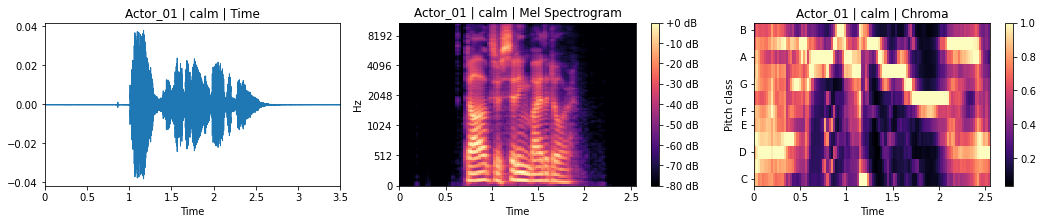

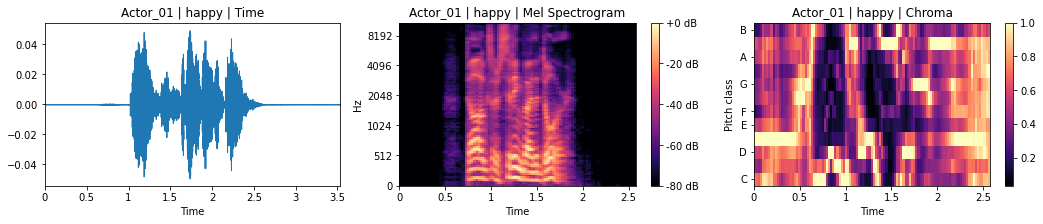

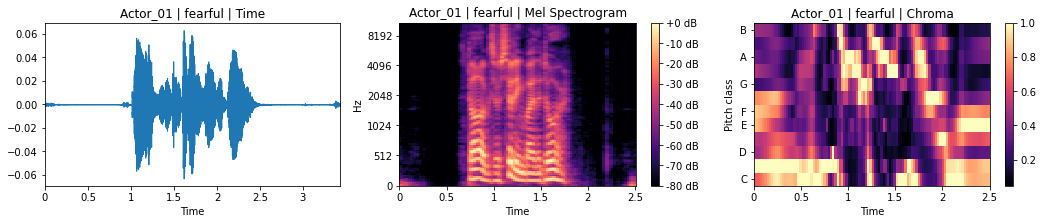

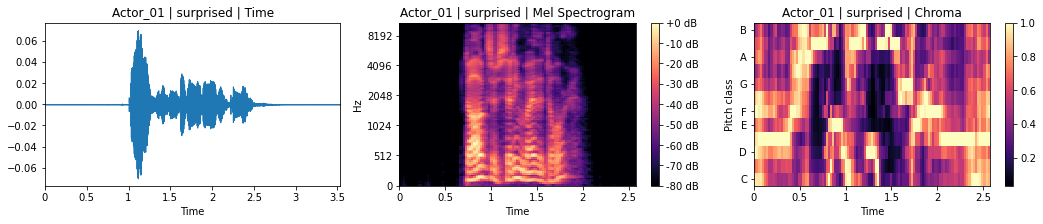

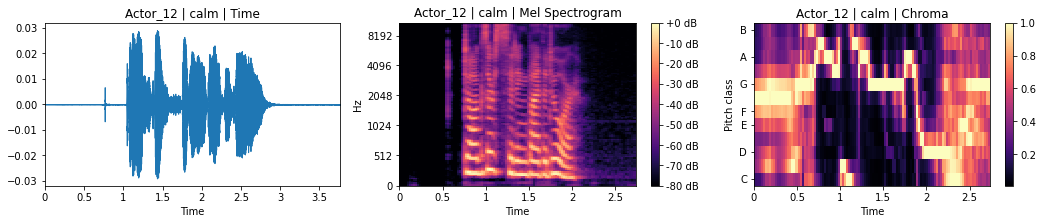

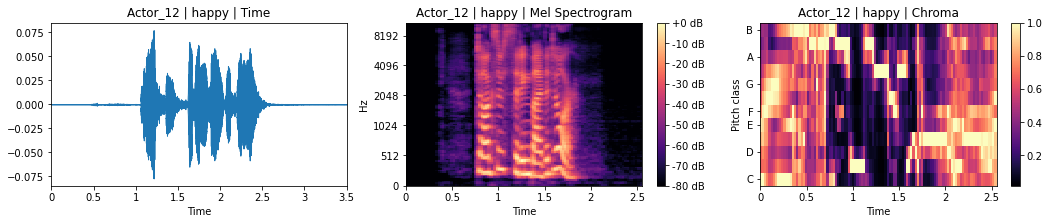

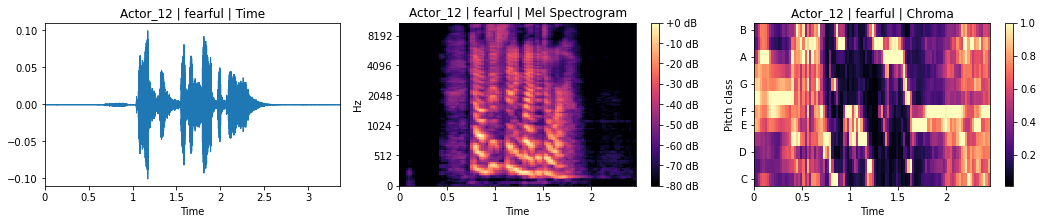

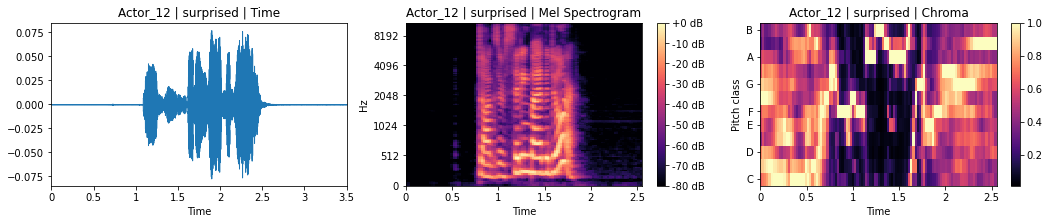

In [5]:
# Choose two sample actors (male and female) and play the files for observed emotions
plt.rcParams["figure.figsize"] = [18,3]
for actor in ['01', '12']:
    for emotion in observed_emotions:
        sample_actor = "Actor_" + actor
        sample_audio_file = dataset_dir + sample_actor + "/03-01-" + inv_emotions[emotion] + "-01-02-01-" + actor + ".wav"
        X, sample_rate=read_soundfile(sample_audio_file)
        Xtitle = sample_actor + " | " + emotion

        fig, axs = plt.subplots(1,3)
        librosa.display.waveplot(X, sr=sample_rate, ax=axs[0])
        axs[0].set_title(Xtitle + " | Time")

        M = librosa.feature.melspectrogram(y=X, sr=sample_rate)
        M_db = librosa.power_to_db(M, ref=np.max)
        img = librosa.display.specshow(M_db, y_axis='mel', x_axis='time', ax=axs[1])
        axs[1].set_title(Xtitle + " | Mel Spectrogram")
        fig.colorbar(img, ax=axs[1], format="%+2.f dB")
        
        chroma = librosa.feature.chroma_cqt(y=X, sr=sample_rate)
        img = librosa.display.specshow(chroma, y_axis='chroma', x_axis='time', ax=axs[2])
        axs[2].set_title(Xtitle + " | Chroma")
        fig.colorbar(img, ax=axs[2])
        

In [6]:
# Utility function to extract MFCC, Chroma from files and create the test vectors
def extract_feature(file_name, mfcc, chroma, mel):
    with soundfile.SoundFile(file_name) as sound_file:
        X = sound_file.read(dtype="float32")
        sample_rate=sound_file.samplerate
        if chroma:
            stft=np.abs(librosa.stft(X))
        result=np.array([])
        if mfcc:
            mfccs=np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
            result=np.hstack((result, mfccs))
        if chroma:
            chroma=np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
            result=np.hstack((result, chroma))
    if mel:
        mel=np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
        result=np.hstack((result, mel))
    return result

In [7]:
# Load the data and extract features for each sound file
def load_data(test_size=0.2):
    x,y=[],[]
    for file in glob.glob("ser-ravdess-data/Actor_*/*.wav"):
        file_name=os.path.basename(file)
        emotion=emotions[file_name.split("-")[2]]
        if emotion not in observed_emotions:
            continue
        feature=extract_feature(file, mfcc=True, chroma=True, mel=True)
        x.append(feature)
        y.append(emotion)
    return train_test_split(np.array(x), y, test_size=test_size, random_state=9)

In [8]:
# Split the dataset - 90% training, 10% test
x_train, x_test, y_train, y_test = load_data(test_size=0.1)

In [9]:
# Get the shape of the training and testing datasets
print(f"Training set size: {x_train.shape[0]}")
print(f"Test set size: {x_test.shape[0]}")
print(f"Features extracted: {x_train.shape[1]}")

Training set size: 691
Test set size: 77
Features extracted: 180


## Model Training
I used the [Multi-layer Perceptron classifier](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html) for this project. This model optimizes the log-loss function using LBFGS or stochastic gradient descent.

In [10]:
# Initialize the Multi Layer Perceptron Classifier
model = MLPClassifier(alpha=0.01, batch_size=256, epsilon=1e-08, hidden_layer_sizes=(300,), learning_rate='adaptive', max_iter=500)
print(model)

MLPClassifier(alpha=0.01, batch_size=256, hidden_layer_sizes=(300,),
              learning_rate='adaptive', max_iter=500)


In [11]:
# Train the model
model.fit(x_train, y_train)

MLPClassifier(alpha=0.01, batch_size=256, hidden_layer_sizes=(300,),
              learning_rate='adaptive', max_iter=500)

In [12]:
print(model)

MLPClassifier(alpha=0.01, batch_size=256, hidden_layer_sizes=(300,),
              learning_rate='adaptive', max_iter=500)


## Model Prediction
Use the trained model on the test data and measure prediction accuracy

In [13]:
# Predict outputs for the test data
y_pred=model.predict(x_test)

In [14]:
# Calculate model accuracy
accuracy=accuracy_score(y_true=y_test, y_pred=y_pred)

# Print model accuracy
print("Accuracy: {:.2f}%".format(accuracy*100))

Accuracy: 80.52%
